# Sentiment classification using the fastText neural classifier model

## Import necessary modules

In [1]:
import numpy as np
from typing import List, Tuple, Dict, Union
from matplotlib import pyplot as plt
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D 
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import History 

## IMDB Corpus

In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

## Data preparation

In [3]:
def load_data_from_folder(folder_path: Path) -> List[str]:
    texts: List[str] = []

    for q in folder_path.rglob('*.txt'):
      texts.append(q.open().readline())

    return texts

In [4]:
def get_data(neg_folder_path: str, pos_folder_path: str) -> Tuple[List[str], List[int]]:
    texts: List[str] = []
    labels: List[int] = []

    neg = load_data_from_folder(Path(neg_folder_path))
    neg_labels = [0]*len(neg)

    pos = load_data_from_folder(Path(pos_folder_path))
    pos_labels = [1]*len(pos)

    texts = neg + pos
    labels = neg_labels + pos_labels

    return texts, labels

In [5]:
def prepare_tokenizer(corpus: List[str]) -> Tokenizer:
    tokenizer = Tokenizer()

    tokenizer.fit_on_texts(corpus)

    return tokenizer

In [6]:
train_corpus = get_data("./aclImdb/train/neg/", "./aclImdb/train/pos/")
test_corpus = get_data("./aclImdb/test/neg/", "./aclImdb/test/pos/")

tokenizer = prepare_tokenizer(train_corpus[0])
# print(tokenizer.word_index)

In [7]:
print(train_corpus[0][0])

There's a lot of movies that have set release dates, only to get pulled from distribution due to a legal snafu of some kind, and then put in limbo for a long time. You can only wish a film as rotten as "Slackers" remained in a coma for what it's worth, which is miniscule. Release dates were continually shifted around for this truly awful movie that is so much a bleep on the radar like it deserves. The premise kicks off under the guise of Ethan, a creepy nerd with a scary obsession for the campus bombshell Angela. Ethan devilishly enlists the aid of David and his friends who have been scamming the school for their entire run with blackmail to help win Angela. I don't like to give spoilers out, but for a piece of crap like this I can make an exception. Angela falls for David, Ethan intentionally screws everything up, the good guys win. That's what happens in a nutshell for another tired retread of the teen gross out genre. Gross humor is funny, it always has been dating back to the days 

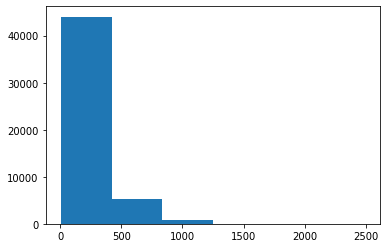

In [8]:
seq_len = []
seq_train = tokenizer.texts_to_sequences(train_corpus[0])
seq_test = tokenizer.texts_to_sequences(test_corpus[0])

for i in range(0, len(seq_train)):
  seq_len.append(len(seq_train[i]))

for i in range(0, len(seq_test)):
  seq_len.append(len(seq_test[i]))

plt.hist(seq_len, 6)
plt.show()

In [9]:
max_sequence_len = 1000
train_input_sequences = pad_sequences(seq_train, maxlen=max_sequence_len, padding='pre')
test_input_sequences = pad_sequences(seq_test, maxlen=max_sequence_len, padding='pre')

test_labels = to_categorical(test_corpus[1])
train_labels = to_categorical(train_corpus[1])

print(len(train_input_sequences))
print(train_input_sequences.shape)
print(train_labels.shape)

25000
(25000, 1000)
(25000, 2)


In [10]:
def plot_history_details(history: History):

    loss_train = history.history['loss']
    acc = history.history['accuracy']
    plt.plot(loss_train, 'g', label='Loss')
    plt.plot(acc, 'b', label='Accuracy')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Classic fastText text classification

In [11]:
def build_fasttext(
    num_classes: int,
    maxlen: int,
    max_features: int) -> Sequential:

    model = Sequential()

    model.add(Embedding(input_dim=max_features, output_dim=64, input_length=maxlen))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [12]:
model: Sequential

model = build_fasttext(2, max_sequence_len, len(tokenizer.word_index) + 1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          5669312   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 5,669,442
Trainable params: 5,669,442
Non-trainable params: 0
_________________________________________________________________


In [13]:
history1: History

history1 = model.fit(x=train_input_sequences, y=train_labels, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
782/782 [==============================] - 14s 13ms/step - loss: 0.4919 - accuracy: 0.8053
Epoch 2/20
782/782 [==============================] - 10s 12ms/step - loss: 0.2756 - accuracy: 0.8927
Epoch 3/20
782/782 [==============================] - 10s 12ms/step - loss: 0.1956 - accuracy: 0.9293
Epoch 4/20
782/782 [==============================] - 10s 12ms/step - loss: 0.1363 - accuracy: 0.9560
Epoch 5/20
782/782 [==============================] - 10s 12ms/step - loss: 0.0911 - accuracy: 0.9766
Epoch 6/20
782/782 [==============================] - 10s 12ms/step - loss: 0.0591 - accuracy: 0.9878
Epoch 7/20
782/782 [==============================] - 10s 12ms/step - loss: 0.0374 - accuracy: 0.9938
Epoch 8/20
782/782 [==============================] - 10s 12ms/step - loss: 0.0231 - accuracy: 0.9977
Epoch 9/20
782/782 [==============================] - 10s 12ms/step - loss: 0.0141 - accuracy: 0.9992
Epoch 10/20
782/782 [==============================] - 10s 12ms/step - loss: 0.008

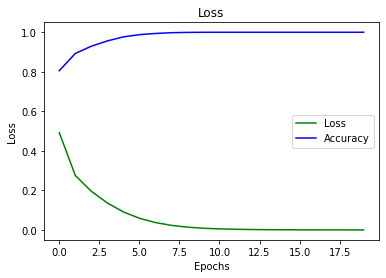

In [14]:
plot_history_details(history1)

In [15]:
print(model.evaluate(test_input_sequences, test_labels))
pred_labels = model.predict(test_input_sequences)

metric = CategoricalAccuracy()
metric.update_state(test_labels, pred_labels)
print(metric.result().numpy())

782/782 [==============================] - 3s 4ms/step - loss: 0.5231 - accuracy: 0.8653
[0.5230996012687683, 0.8653200268745422]
0.86532


## Model with pretrained fastText embeddings

In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2022-05-03 14:31:54--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  76.2MB/s    in 8.9s    

2022-05-03 14:32:04 (73.0 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [17]:
def load_vectors(fname: str, tokenizer: Tokenizer) -> Tuple[Dict[str, List[float]], int]:

    with open(fname, 'r', encoding="utf8", newline='\n', errors='ignore') as fin:
        data: Dict[str, List[float]] = {}

        n, d = map(int, fin.readline().split())
        embedding_dim = d

        for line in fin:
            stripped_line = line.split()

            if stripped_line[0] in tokenizer.word_index:
                float_list = [float(i) for i in stripped_line[1:]]
                data[stripped_line[0]] = float_list

        for word in tokenizer.word_index:
            if word not in data.keys():
                data[word] = [0]*300

        return data, embedding_dim

In [18]:
vectors, embedding_dim = load_vectors("wiki-news-300d-1M.vec", tokenizer)

In [19]:
def transform_vector_data_to_matrix(data: Dict[str, List[float]], embedding_dim: int)-> np.ndarray:
    embedding_matrix: np.ndarray
    
    embedding_matrix = []
    for key in data:
      embedding_matrix.append(data[key])

    embedding_matrix = np.array(embedding_matrix)

    return embedding_matrix
  
embedding_matrix = transform_vector_data_to_matrix(vectors, embedding_dim)

In [20]:
print(embedding_matrix.shape)

(88582, 300)


In [21]:
def build_fasttext_pretrained(
    num_classes: int,
    maxlen: int, 
    max_features: int,
    embedding_matrix: np.ndarray,
    embedding_dim: int,
    loss_func: str='categorical_crossentropy',
    activation: str = 'softmax', 
    metrics: List[str]=['accuracy']):

    model = Sequential()

    model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation=activation))

    model.compile(optimizer='adam', loss=loss_func, metrics=metrics)

    return model

In [22]:
pre_trained_model: Sequential

pre_trained_model = build_fasttext_pretrained(2, max_sequence_len, len(tokenizer.word_index), embedding_matrix, embedding_dim)

pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         26574600  
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 2)                 602       
                                                                 
Total params: 26,575,202
Trainable params: 26,575,202
Non-trainable params: 0
_________________________________________________________________


In [23]:
history2 = pre_trained_model.fit(x=train_input_sequences, y=train_labels, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
782/782 [==============================] - 30s 38ms/step - loss: 0.5107 - accuracy: 0.7754
Epoch 2/20
782/782 [==============================] - 27s 35ms/step - loss: 0.2187 - accuracy: 0.9271
Epoch 3/20
782/782 [==============================] - 28s 35ms/step - loss: 0.1067 - accuracy: 0.9739
Epoch 4/20
782/782 [==============================] - 28s 35ms/step - loss: 0.0466 - accuracy: 0.9929
Epoch 5/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0192 - accuracy: 0.9985
Epoch 6/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0084 - accuracy: 0.9999
Epoch 7/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 8/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 9/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 10/20
782/782 [==============================] - 28s 36ms/step - loss: 7.672

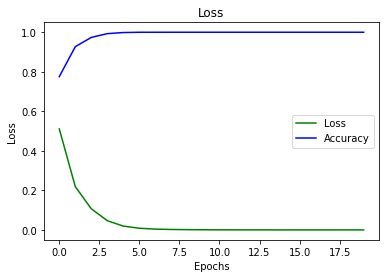

In [24]:
plot_history_details(history2)

In [25]:
print(pre_trained_model.evaluate(test_input_sequences, test_labels))
pred_labels = pre_trained_model.predict(test_input_sequences)

metric = CategoricalAccuracy()
metric.update_state(test_labels, pred_labels)
print(metric.result().numpy())

782/782 [==============================] - 4s 5ms/step - loss: 0.4788 - accuracy: 0.8696
[0.47882917523384094, 0.8696399927139282]
0.86964


## Model with subword tokenization and embeddings

In [26]:
!pip install bpemb

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [27]:
from bpemb import BPEmb
bpemb_en = BPEmb(lang="en", vs=25000)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.model


100%|██████████| 661443/661443 [00:00<00:00, 1266117.69B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9477142/9477142 [00:01<00:00, 7736373.79B/s] 


In [28]:
train_corpus_BP = get_data("./aclImdb/train/neg/", "./aclImdb/train/pos/")
test_corpus_BP = get_data("./aclImdb/test/neg/", "./aclImdb/test/pos/")

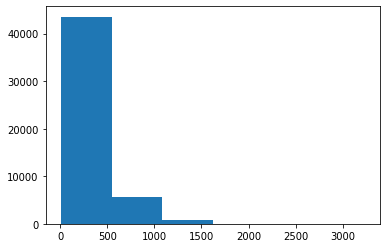

In [29]:
subword_sequence_len = []
sub_train = bpemb_en.encode_ids(train_corpus_BP[0])
sub_test = bpemb_en.encode_ids(test_corpus_BP[0])

for i in range(0, len(sub_train)):
  subword_sequence_len.append(len(sub_train[i]))

for i in range(0, len(sub_test)):
  subword_sequence_len.append(len(sub_test[i]))
  

plt.hist(subword_sequence_len, 6)
plt.show()

In [30]:
max_subword_sequence_len = 1500
train_input_subword_sequences = pad_sequences(sub_train, maxlen=max_subword_sequence_len, padding='pre')
test_input_subword_sequences = pad_sequences(sub_test, maxlen=max_subword_sequence_len, padding='pre')

train_BP_labels = to_categorical(train_corpus_BP[1])
test_BP_labels = to_categorical(test_corpus_BP[1])

print(len(train_input_subword_sequences))
print(train_input_subword_sequences.shape)

25000
(25000, 1500)


In [31]:
def build_subword(
    num_classes: int,
    maxlen: int,
    bpemb_vectors ,
    loss_func: str = 'categorical_crossentropy',
    activation: str = 'softmax',
    metrics: List[str] = ['accuracy']) -> Sequential:

    model = Sequential()

    model.add(Embedding(input_dim=len(bpemb_vectors), output_dim=100, weights=[bpemb_vectors], input_length=maxlen, trainable=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation=activation))

    model.compile(optimizer='adam', loss=loss_func, metrics=metrics)

    return model

In [32]:
subword_model = build_subword(2, max_subword_sequence_len, bpemb_en.vectors)

subword_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1500, 100)         2500000   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 2,500,202
Trainable params: 2,500,202
Non-trainable params: 0
_________________________________________________________________


In [33]:
history3 = subword_model.fit(x=train_input_subword_sequences, y=train_BP_labels, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
782/782 [==============================] - 11s 14ms/step - loss: 0.6325 - accuracy: 0.6520
Epoch 2/20
782/782 [==============================] - 11s 14ms/step - loss: 0.4467 - accuracy: 0.8172
Epoch 3/20
782/782 [==============================] - 11s 14ms/step - loss: 0.3329 - accuracy: 0.8691
Epoch 4/20
782/782 [==============================] - 11s 13ms/step - loss: 0.2649 - accuracy: 0.9000
Epoch 5/20
782/782 [==============================] - 11s 13ms/step - loss: 0.2145 - accuracy: 0.9230
Epoch 6/20
782/782 [==============================] - 11s 13ms/step - loss: 0.1745 - accuracy: 0.9416
Epoch 7/20
782/782 [==============================] - 11s 13ms/step - loss: 0.1405 - accuracy: 0.9580
Epoch 8/20
782/782 [==============================] - 10s 13ms/step - loss: 0.1125 - accuracy: 0.9703
Epoch 9/20
782/782 [==============================] - 11s 14ms/step - loss: 0.0884 - accuracy: 0.9797
Epoch 10/20
782/782 [==============================] - 11s 14ms/step - loss: 0.068

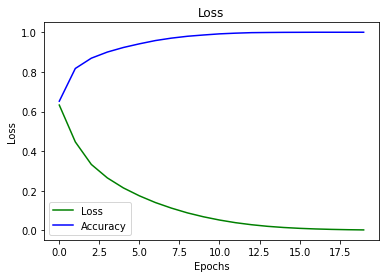

In [34]:
plot_history_details(history3)

In [35]:
print(subword_model.evaluate(test_input_subword_sequences, test_BP_labels))
pred_labels = subword_model.predict(test_input_subword_sequences)

metric = CategoricalAccuracy()
metric.update_state(test_BP_labels, pred_labels)
print(metric.result().numpy())

782/782 [==============================] - 4s 5ms/step - loss: 0.6003 - accuracy: 0.8282
[0.6003108620643616, 0.8281999826431274]
0.8282
